In [1]:
import os
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import cv2

import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim

from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.preprocessing import OneHotEncoder
from torchvision import transforms
from tqdm import tqdm


## Load the dataset with Plain_Dataset class 

In [2]:
class Plain_Dataset(Dataset):
    def __init__(self,csv_file,img_dir,datatype,transform):
        '''
        Class inheret from Dataset pytorch class 
        the overrided methods used to collect the custom dataset (FER2013)
        [Note] NO OneHot encoding is used with pytorch
        '''
        self.csv_file = pd.read_csv(csv_file)
        self.lables = self.csv_file['emotion']
        self.img_dir = img_dir
        self.transform = transform
        self.datatype = datatype

    def __len__(self):
        return len(self.csv_file)

    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img = Image.open(self.img_dir+self.datatype+str(idx)+'.jpg')
        lables = np.array(self.lables[idx])
        lables = torch.from_numpy(lables).long()


        if self.transform :
            img = self.transform(img)


        return img,lables


In [3]:
transformation = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
dataset = Plain_Dataset(csv_file='Dataset/Kaggle/test.csv',img_dir = 'test/',datatype = 'test',transform = transformation)
test_loader =  DataLoader(dataset,batch_size=64,num_workers=0)

#### Test the dataloader

tensor(4)


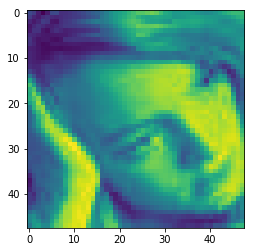

In [4]:
imgg = dataset.__getitem__(250)[0]
lable = dataset.__getitem__(250)[1]

print(lable)
#(0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)
imgnumpy = imgg.numpy()
imgt = imgnumpy.squeeze()
plt.imshow(imgt)
plt.show()

## Load the model

In [5]:
class Deep_Emotion(nn.Module):
    def __init__(self):
        '''
        Documentation
        '''
        super(Deep_Emotion,self).__init__()
        self.conv1 = nn.Conv2d(1,10,3)
        self.conv2 = nn.Conv2d(10,10,3)
        self.pool2 = nn.MaxPool2d(2,2)

        self.conv3 = nn.Conv2d(10,10,3)
        self.conv4 = nn.Conv2d(10,10,3)
        self.pool4 = nn.MaxPool2d(2,2)

        #self.dropout = nn.Dropout2d()

        self.fc1 = nn.Linear(810,50)
        self.fc2 = nn.Linear(50,7)

    def forward(self,input):
        out = self.conv1(input)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.pool2(out)
        out = F.relu(out)

        out = self.conv3(out)
        out = F.relu(out)

        out = self.conv4(out)
        out = self.pool4(out)
        out = F.relu(out)

        out = F.dropout(out)
        out = out.view(-1, 810) #####
        out = self.fc1(out)
        out = self.fc2(out)

        return out

In [6]:
model = torch.load("model_noSTN-20-128-0.005.pt")

c:\users\omar sayed\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:401: UserWarning: Couldn't retrieve source code for container of type Deep_Emotion. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "


## Model Evaluation 

In [7]:
model.eval()
total = []
with torch.no_grad():
    for data, lables in test_loader:
        data, lables = data.cuda(), lables.cuda()
        outputs = model(data)
        pred = F.softmax(outputs)
        classs = torch.argmax(pred,1)
        wrong = torch.where(classs != lables,torch.tensor([1.]).cuda(),torch.tensor([0.]).cuda())
        acc = 1- (torch.sum(wrong) / 64)
        total.append(acc.item())

print('Accuracy of the network on the test images: %d %%' % (100 * np.mean(total)))

c:\users\omar sayed\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


Accuracy of the network on the test images: 45 %


### Accuarcy of each class

In [8]:
classes = ('Angry', 'Disgust', 'Fear', 'Happy','Sad', 'Surprise', 'Neutral')
class_correct = list(0. for i in range(7))
class_total = list(0. for i in range(7))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(7):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of Angry : 42 %
Accuracy of Disgust :  0 %
Accuracy of  Fear :  7 %
Accuracy of Happy : 73 %
Accuracy of   Sad : 35 %
Accuracy of Surprise : 47 %
Accuracy of Neutral : 30 %


### Confusion matrix

In [9]:
#helper function
def get_correct_pred(preds,labels):
    """
    preds : tensor with all predictions 
    labels : tensor with all correct labels 
    return the sum of all correct predictions then divide the number over the overall test examples to get the test accuracy 
    """
    return preds.cuda().argmax(dim=1).eq(labels.cuda()).sum().item()

In [10]:
#helper function for plotting the confusion matrix 
@torch.no_grad() #grad tracking disabled 
def get_all_preds(model,loader):
    """
    model : the pretrained network object
    loader : data loader maybe (training, validation, test)
    return tensor contain all the predictions of the dataloader passed 
    """
    all_preds = torch.tensor([]).cuda()
    all_targets = torch.tensor([]).cuda()
    for batch in loader :
        imgs, labels = batch
        labels = torch.tensor(labels,dtype=torch.float32)
        
        imgs, labels = imgs.cuda(), labels.cuda()
        
        preds = model(imgs)
        
        all_preds = torch.cat((all_preds,preds),dim=0)
        all_targets = torch.cat((all_targets,labels),dim=0)
    
    all_targets = torch.tensor(all_targets,dtype=torch.long)    
    return all_targets, all_preds
    

In [11]:
with torch.no_grad():
    all_targets, all_preds = get_all_preds(model,test_loader)

c:\users\omar sayed\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
c:\users\omar sayed\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [12]:
all_preds.shape

torch.Size([3589, 7])

In [13]:
all_preds[0]

tensor([ 1.5218, -1.7244,  0.4855,  1.4294, -0.8410,  0.6596, -0.4255],
       device='cuda:0')

In [14]:
all_targets.shape

torch.Size([3589])

In [15]:
all_targets

tensor([0, 1, 4,  ..., 4, 4, 4])

In [16]:
num_of_correct_preds = get_correct_pred(all_preds,all_targets)

In [17]:
num_of_correct_preds

1590

In [18]:
test_accuarcy = num_of_correct_preds / len(all_targets)
print("Test Accuarcy {: 3f}%".format(100*test_accuarcy))

Test Accuarcy  44.302034%


In [19]:
all_preds = all_preds.argmax(dim=1).cuda()

In [20]:
all_targets = all_targets.cuda()

In [21]:
#stack the two previous tensors to bulid the confusion matrix 
stacked = torch.stack((all_targets,all_preds),dim=1)

In [22]:
stacked

tensor([[0, 0],
        [1, 0],
        [4, 2],
        ...,
        [4, 3],
        [4, 0],
        [4, 6]], device='cuda:0')

In [23]:
stacked.shape

torch.Size([3589, 2])

In [24]:
#the confusion tensor 
c_m = torch.zeros((7,7),dtype=torch.int64)

In [25]:
c_m

tensor([[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]])

In [26]:
#loop to fill the c_m tensor with the required numbers 
for p in stacked:
    t, p = p.tolist()
    c_m[t,p] = c_m[t,p] + 1

##### Confusion Matrix 

In [27]:
c_m

tensor([[190,   0,  25,  67,  92,  18,  75],
        [ 25,   0,   3,   6,  13,   3,   6],
        [ 83,   1,  57,  94, 107,  62,  92],
        [ 62,   0,  17, 633,  69,  21,  93],
        [102,   0,  37, 128, 208,  32, 146],
        [ 43,   0,  22,  46,  25, 247,  32],
        [ 76,   0,  24,  95, 132,  25, 255]])

## Test Custom image

In [28]:
loader = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
def load_img(path):
    img = Image.open(path)
    img = loader(img).float()
    img = torch.autograd.Variable(img,requires_grad = True)
    img = img.unsqueeze(0)
    return img.cuda()

def test_img(path,save_name):
    #scale and convert to grayscale then save the image to import it with PIL.Image
    img = cv2.imread(path,0)
    img = cv2.resize(img,(48,48))
    cv2.imwrite(save_name,img)
    
    #load saved image with PIL
    PIL_img = load_img(path)
    out = model(PIL_img)
    pred = F.softmax(out)
    classs = torch.argmax(pred,1)
    wrong = torch.where(classs != 3,torch.tensor([1.]).cuda(),torch.tensor([0.]).cuda())
    classs = torch.argmax(pred,1)
    prediction = classes[classs.item()]
    print(prediction)

In [29]:
test_img('test2.jpg','test2.jpg')

c:\users\omar sayed\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Happy


## Test on Real-time

In [30]:
import cv2

# Load the cascade
face_cascade = cv2.CascadeClassifier('facedetection-master/haarcascade_frontalface_default.xml')

# To capture video from webcam. 
cap = cv2.VideoCapture(0)

while True:
    # Read the frame
    _, img = cap.read()

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect the faces
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)

    # Draw the rectangle around each face
    for (x, y, w, h) in faces:
        roi = img[y:y+h, x:x+w]
        roi = cv2.cvtColor(roi,cv2.COLOR_BGR2GRAY)
        roi = cv2.resize(roi,(48,48))
        cv2.imwrite("roi.jpg", roi)
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)

    imgg = load_img("roi.jpg")
    out = model(imgg)
    pred = F.softmax(out)
    classs = torch.argmax(pred,1)
    wrong = torch.where(classs != 3,torch.tensor([1.]).cuda(),torch.tensor([0.]).cuda())
    classs = torch.argmax(pred,1)
    prediction = classes[classs.item()]    

    font = cv2.FONT_HERSHEY_SIMPLEX   
    org = (50, 50) 
    fontScale = 1
    color = (255, 0, 0) 
    thickness = 2
    img = cv2.putText(img, prediction, org, font,  
                   fontScale, color, thickness, cv2.LINE_AA)
    
    cv2.imshow('img', img)
    # Stop if (Q) key is pressed
    k = cv2.waitKey(30) 
    if k==ord("q"):
        break
        
# Release the VideoCapture object
cap.release()

c:\users\omar sayed\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


KeyboardInterrupt: 